In [1]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # #                                         # # # # # # #
# # # # # # #             Dimple Surface              # # # # # # # 
# # # # # # #                                         # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [2]:
from veech import *

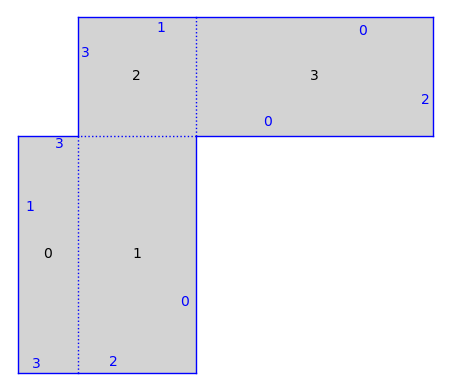

In [3]:
def define_dimple(x,y):

    def rectangle(a,b):
        return polygons(vertices = [(0,0),(a,0),(a,b),(0,b)])

    P1 = rectangle(x,y)
    Q1 = rectangle(1,y)
    R1 = rectangle(1,1)
    S1 = rectangle(y,1)
    
    s = Surface_list(QQ)

    s.add_polygon(P1)
    s.add_polygon(Q1)
    s.add_polygon(R1)
    s.add_polygon(S1)

    S = SimilaritySurface(s)

    s.set_edge_pairing(0,0,3,2)
    s.set_edge_pairing(0,1,1,3)
    s.set_edge_pairing(0,2,3,0)
    s.set_edge_pairing(0,3,1,1)
    s.set_edge_pairing(1,0,2,2)
    s.set_edge_pairing(1,2,2,0)
    s.set_edge_pairing(2,1,3,3)
    s.set_edge_pairing(2,3,3,1)

    gs = S.graphical_surface()

    gs.make_adjacent(1,2)
    gs.make_adjacent(2,1)    
    
    DS = S.minimal_cover(cover_type='dilation').copy(relabel=True)
    
    return DS, S, gs, s

DS, S, gs, s = define_dimple(1/2,2)
gs.plot()


# We first imagined the Dimple surface as a (1 by 1) square torus surface
# with an (x by x) square cut out, and replaced by a (1 by y) rectangle.
# 
# Then, we chose a presentation with the cut-out in the lower-left corner.
# 
# The simplest presentation might be the following reparameterization:
# Normalize Box 2 to be a unit square, and let x and y vary as the height and width of Box 0, respecetively.

In [4]:
def search_dimple(x,y,iters=10):
    DS, S, gs, s = define_dimple(x,y)
    print('x,y = ' + str(x) + ', ' + str(y))
    IDC1 = IDC(DS, iters, veech = 1, show_current_sym = 0) # Change 1 to > 100
    show(IDC1.plot(model = 'UHP', figsize = 5)) #UHP or KM
    gs.plot()
    show(list(IDC1.generators(normalize_det=1)))
    
# Using FlatSurf, we are searching for Veech elements under certain simple parameters.
# Under the number of iterations we've tried, Flatsurf doesn't terminate for any of the following,
# it just keeps finding more and more veech elements.

x,y = 1/2, 1

IDR 10/10 --> 1.06 seconds


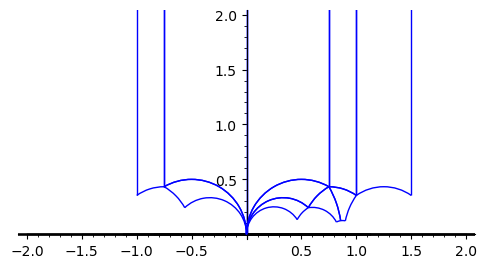

[
[-1  0]
[ 0 -1]
]

x,y = 1/3, 1

IDR 10/10 --> 0.95 seconds


/private/var/tmp/sage-9.6-current/local/var/lib/sage/venv-python3.10.3/lib/python3.10/site-packages/sage/rings/qqbar.py:2865: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  roots = p.roots(ring, False)


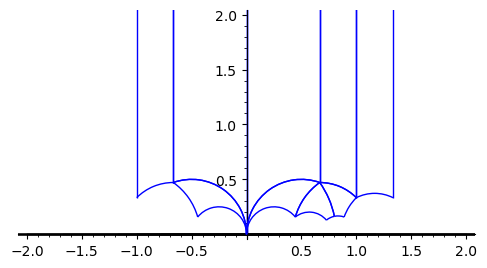

[
[1 0]  [-1  0]
[4 1], [ 0 -1]
]

x,y = 1/4, 1

IDR 10/10 --> 0.95 seconds


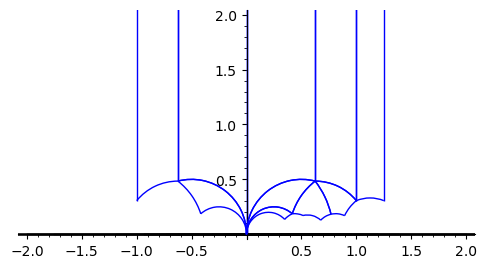

[
[-1  0]
[ 0 -1]
]

In [5]:
# search_dimple(1,1) This is the square torus.
search_dimple(1/2,1)
search_dimple(1/3,1)
search_dimple(1/4,1)

In [6]:
# The horizontal left-right sheers are generated by    [[1,z],    where  z = lcm( (x + 1)/y, y + 1).
#                                                       [0,1]]
#                                                               
# 
# The vertical up-down sheers are generated by         [[1, 0],   where z' = lcm(1/(y+1), xy/(y^2 + x)).
#                                                       [z',1]]
#                                                               
# 
# This is because the surface decomposes into horizontal cylinders of moduli (x + 1)/y and y + 1,
# and it decomposes into vertical cylinders of moduli 1/(y+1) and xy/(y^2 + x).
# 
# These formulas match the results produced above,
# namely, the entries 6, 4, and 10 in the first matrices of the above three groups.

In [39]:
DS, S, gs, s = define_dimple(1/2,1)
IDC1 = IDC(DS, 40, veech = 1, show_current_sym = 0) # Change 1 to > 100
# show(IDC1.plot(model = 'UHP', figsize = 5)) #UHP or KM
# gs.plot()
veech_matrices = list(IDC1.generators(normalize_det=1))
show(veech_matricesa)

# Using FlatSurf, we are searching for Veech elements under certain simple parameters.
# Under the number of iterations we've tried, Flatsurf doesn't terminate for any of the following,
# it just keeps finding more and more veech elements.


IDR 40/40 --> 2.83 seconds


[
[1 0]  [-1  0]
[6 1], [ 0 -1]
]

In [8]:
# What to make of all the non-integer results? (i.e. the non-triangular matrices?)
# Are they products of these horizontal and vertical sheers?
# Or are they something else entirely?

In [9]:
DS, S, gs, s = define_dimple(1/2,1)

In [10]:
A = matrix([[14, 39],
            [5, 14]])

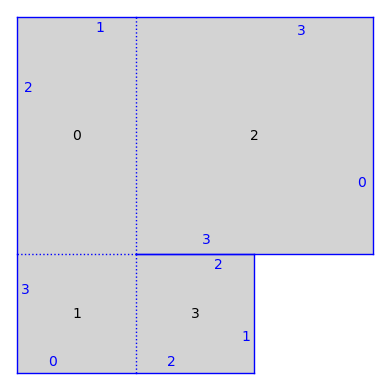

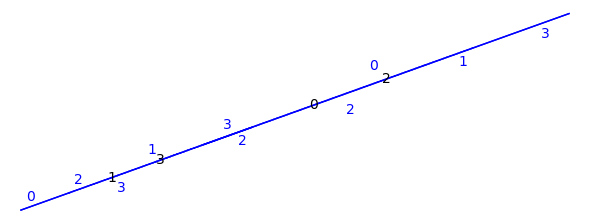

In [11]:
show(DS.plot())
show((A*DS).plot())

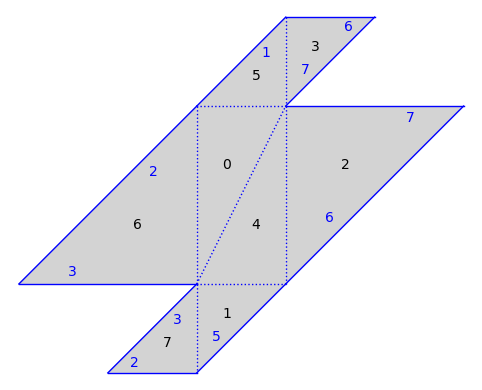

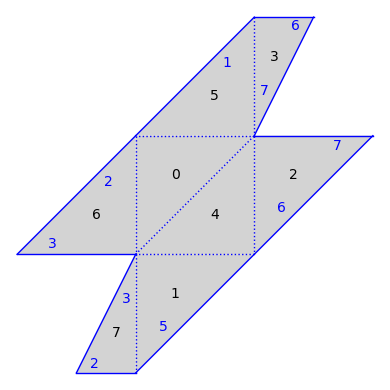

In [12]:
show((DS).delaunay_triangulation().plot())
show((A*DS).delaunay_triangulation().plot())

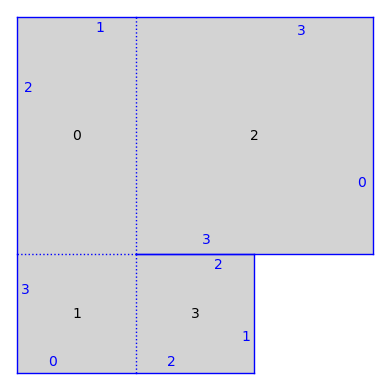

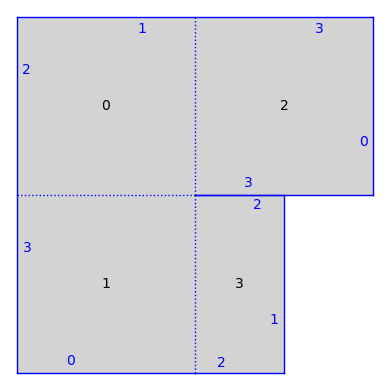

In [13]:
show(DS.delaunay_decomposition().plot())
show((A*DS).delaunay_decomposition().plot())

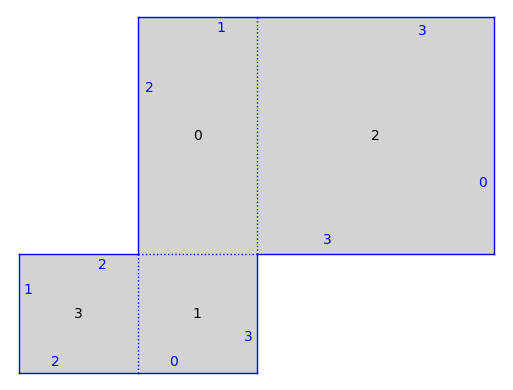

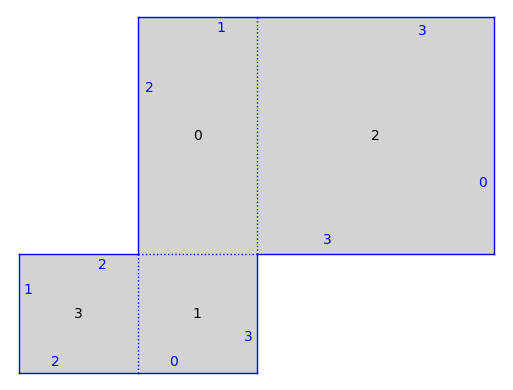

In [14]:
show(DS.canonicalize().plot())
show((A*DS).canonicalize().plot())

In [15]:
print((A*DS).delaunay_triangulation() == DS.delaunay_triangulation())
print((A*DS).delaunay_decomposition() == DS.delaunay_decomposition())
print(DS.canonicalize() == (A*DS).canonicalize())

False
False
True


In [97]:
DS, S, gs, s = define_dimple(1/2,1)
IDC1 = IDC(DS, 3000, veech = 1, show_current_sym = 0)
veech_matrices = list(IDC1.generators(normalize_det=1))


IDR 3000/3000 --> 502.22 seconds


veech_matrices:


[
[-29 -45]  [ 29 -45]  [-161 -180]  [1 6]  [ 14 -39]  [ 31 -45]
[ 20  31], [ 20 -31], [-144 -161], [0 1], [ -5  14], [ 20 -29],

[-17   8]  [ 21 -44]  [1 0]  [-65 -38]  [-23 -44]  [14 39]
[-32  15], [ 11 -23], [6 1], [-53 -31], [ 11  21], [ 5 14],

[ 797/4  549/4]  [-31 -38]  [-15  -8]  [19/2  7/2]  [-1  0]
[1157/4  797/4], [-53 -65], [ 32  17], [51/2 19/2], [ 0 -1]
]


eigenvectors:
0  : (1, -2/3)
1  : (1, 2/3)
2  : (1, 0.8944271909999159?)
3  : (1, 0)
4  : (1, 0.3580574370197165?)
5  : (1, 2/3)
6  : (1, 2)
7  : (1, 1/2)
8  : (0, 1)
9  : (1, 0.8155153211265081?)
10 : (1, -1/2)
11 : (1, -0.3580574370197165?)
12 : (1, -1.451712135329029?)
13 : (1, 1.710252163231772?)
14 : (1, -2)
15 : (1, -2.699206232527312?)
16 : (1, 0)

choose: veech matrix:
[1 0]
[6 1]

choose: eigenvector:
[0, 1]

closed: True
saddle: False


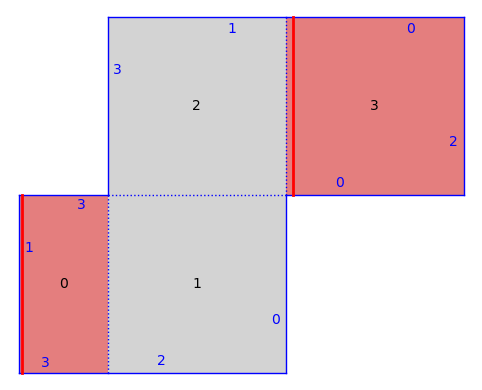

In [99]:
i = 8

veech_matrices = veech_elements

print('veech_matrices:')
show(veech_matrices)

print('\neigenvectors:')
count = 0
for m in veech_matrices:
    print(str(count) + ' '*(count<10) + ' : ' + str(m.eigenvectors_right()[0][1][0]))
    count += 1
    
print('\nchoose: veech matrix:')
print(veech_matrices[i])

print('\nchoose: eigenvector:')
eigen = list(veech_matrices[i].eigenvectors_right()[0][1][0])
print(eigen)

v = S.tangent_vector(0, (1/51,1/51), eigen)
traj = v.straight_line_trajectory()
traj.flow(1000)
print('\nclosed: ' + str(traj.is_closed()))
print('saddle: ' + str(traj.is_saddle_connection()))
show(S.plot() + traj.cylinder().plot(alpha=.4, color = 'red') + traj.plot(color='red', thickness = 2))

In [90]:
# sage: cyl.holonomy()
# (3*a + 4, 2*a + 3)
# sage: cyl.edges()
# (2, 3, 3, 2, 4)
# cyl.polygons()
# b = cyl.boundary()